In [1]:
import numpy as np
import os

import yaml
import random
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax.numpy as jnp
import jax
import optax
import matplotlib.pyplot as plt

seed=10
np.random.seed(seed)

def create_coordinate_set(x1, y1, x2, y2):
    if x1 == x2:
        coords = [
            (x1, i)
            for i in range(y1, y2 + (-1 if y1 > y2 else 1), -1 if y1 > y2 else 1)
        ]
    elif y1 == y2:
        coords = [
            (i, y1)
            for i in range(x1, x2 + (-1 if x1 > x2 else 1), -1 if x1 > x2 else 1)
        ]
    return np.array(coords)


def generate_random_path(grid, start, end):
    def find_path(current_position, visited):
        if current_position == end:
            return [current_position]

        possible_moves = []
        row, col = current_position
        rows, cols = grid.shape

        if row > 0 and grid[row - 1, col] == 1 and (row - 1, col) not in visited:
            possible_moves.append((-1, 0))
        if row < rows - 1 and grid[row + 1, col] == 1 and (row + 1, col) not in visited:
            possible_moves.append((1, 0))
        if col > 0 and grid[row, col - 1] == 1 and (row, col - 1) not in visited:
            possible_moves.append((0, -1))
        if col < cols - 1 and grid[row, col + 1] == 1 and (row, col + 1) not in visited:
            possible_moves.append((0, 1))

        if (
            row > 0
            and col > 0
            and grid[row - 1, col - 1] == 1
            and (row - 1, col - 1) not in visited
        ):
            possible_moves.append((-1, -1))
        if (
            row > 0
            and col < cols - 1
            and grid[row - 1, col + 1] == 1
            and (row - 1, col + 1) not in visited
        ):
            possible_moves.append((-1, 1))
        if (
            row < rows - 1
            and col > 0
            and grid[row + 1, col - 1] == 1
            and (row + 1, col - 1) not in visited
        ):
            possible_moves.append((1, -1))
        if (
            row < rows - 1
            and col < cols - 1
            and grid[row + 1, col + 1] == 1
            and (row + 1, col + 1) not in visited
        ):
            possible_moves.append((1, 1))

        if not possible_moves:
            return []

        next_move = possible_moves[np.random.choice(len(possible_moves))]
        new_position = (
            current_position[0] + next_move[0],
            current_position[1] + next_move[1],
        )
        path = find_path(new_position, visited + [current_position])

        return [current_position] + path if path is not None else None

    path = find_path(start, [])
    return np.array(path) if path is not None else None


def saveimg(data, save_path):
    fig, ax = plt.subplots()

    im = ax.imshow(data, cmap="gray", alpha=0.9)

    # Add a title
    ax.set_title("Estimate cost V")

    # Add labels to the x-axis and y-axis
    ax.set_xlabel("X-Axis")
    ax.set_ylabel("Y-Axis")

    # Add a colorbar
    fig.colorbar(im)
    for (j,i),label in np.ndenumerate(data):
        ax.text(i,j,"{:.2f}".format(label),ha='center',va='center')
    dirname = os.path.dirname(save_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    plt.savefig(save_path)
    plt.close()

grid_shape = (7, 7)
settingname="setting4"
expert_trajs = np.load(f"/home/guorui/jax-rl/expert_data/grid_world/{settingname}/expert_trajs.npz")
expert_trajs = [expert_trajs[name] for name in expert_trajs.files]

with open(f'/home/guorui/jax-rl/expert_data/grid_world/{settingname}.yaml') as f:
    config=yaml.safe_load(f)

# sample_trajs = np.load("expert_data/grid_world/setting2/sample_trajs.npz")

# sample_trajs = [sample_trajs[name] for name in sample_trajs.files]


start_point = tuple(expert_trajs[0][0].tolist())
end_point = tuple(expert_trajs[0][-1].tolist())
# expert_trajs = [traj[:6] for traj in expert_trajs]
sample_trajs = []
random_path = [
    generate_random_path(np.ones(grid_shape), start_point, end_point)
    for i in range(50)
]
sample_trajs += random_path
if (0,6) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (0, 6), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (6,0) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (6, 0), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (0,0) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (0, 0), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (6,6) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (6, 6), end_point) for i in range(20)
    ]
    sample_trajs += random_path
d_0 = np.zeros(grid_shape)
d_0[start_point] = 1

d_ab = np.zeros(grid_shape)
d_ab[end_point] = 1


gamma = 1

beta = 0.5


def calculate_traj_distances(traj):
    r = (traj[1:] == end_point).all(axis=1) - 1

    d = np.power(gamma, np.arange(len(traj) - 1))
    return d, r




rho_S = np.zeros((*grid_shape, *grid_shape))
rho_E = np.zeros((*grid_shape, *grid_shape))

for traj in expert_trajs:
    rho_E[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1
for traj in sample_trajs:
    rho_S[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1

state_ocuupy_E = np.zeros(grid_shape)
for traj in expert_trajs:
    state_ocuupy_E[traj[:-1, 0], traj[:-1, 1]] += 1


rho = (beta * rho_E + (1 - beta) * rho_S) / (
    (beta * rho_E + (1 - beta) * rho_S).sum((-1, -2))
).clip(0.1)[..., None, None]
expert_d = rho_E / rho_E.sum((-1, -2)).clip(1)[..., None, None]
expert_d[(expert_d<1)&(expert_d>0)]=0.5


# weight_e=[]
# for traj in expert_trajs:
#     weight_e.append((expert_d[traj[:-1, 0], traj[:-1:, 1]]!=0).sum((-1,-2)).prod())
# print(weight_e)
# target_E = np.concatenate(
#     [
#         (expert_d / rho)[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
#         for traj in expert_trajs
#     ]
# )
# target_S = np.concatenate(
#     [
#         (expert_d / rho)[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
#         for traj in sample_trajs
#     ]
# )
target_E = np.concatenate(
    [
        expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
        for traj in expert_trajs
    ]
)
target_S = np.concatenate(
    [
        expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
        for traj in sample_trajs
    ]
)


def get_all_data(trajs, rho):
    d_E, r_E = list(zip(*[calculate_traj_distances(traj) for traj in trajs]))
    d_E = np.concatenate(d_E)
    r_E = np.concatenate(r_E)
    rho_E = np.concatenate(
        [rho[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] for traj in trajs]
    )
    return rho_E, d_E, r_E


show_S = np.concatenate(
    [state_ocuupy_E[traj[:-1:, 0], traj[:-1, 1]] != 0 for traj in sample_trajs]
)
rho_E, d_E, r_E = get_all_data(expert_trajs, rho)
rho_S, d_S, r_S = get_all_data(sample_trajs, rho)

obs_E = np.concatenate([traj[:-1] for traj in expert_trajs])
obs_next_E = np.concatenate([traj[1:] for traj in expert_trajs])

obs_S = np.concatenate([traj[:-1] for traj in sample_trajs])
obs_next_S = np.concatenate([traj[1:] for traj in sample_trajs])


def calculate_y(obs, obs_next, V):
    y = gamma * V[obs_next[:, 0], obs_next[:, 1]] - V[obs[:, 0], obs[:, 1]]
    return y,  V[obs[:, 0], obs[:, 1]],V[obs_next[:, 0], obs_next[:, 1]]

def get_V(V):
    y_E, V_E, next_V_E = calculate_y(obs_E, obs_next_E, V)
    y_S, V_S, next_V_S = calculate_y(obs_S, obs_next_S, V)
    return (y_E, V_E, next_V_E), (y_S, V_S, next_V_S)


lamb = 0.7

# def f_div(x):
#     return x*jnp.log(x)

# def omega_star(y):
#     return jnp.exp(y-1)

def f_div(x):
    return (x-1)**2

def omega_star(y):
    return (y / 2 + 1).clip(0)


def fp_star(y):
    return omega_star(y) * y - f_div(omega_star(y))



cost_max=0
cost_min=-jnp.inf

@jax.jit
def dualrewardV(reward_V, V):

    (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(reward_V)
    (cost_y_E, _, _), (cost_y_S, _, _) = get_V(V)
    cost_y_E = cost_y_E.clip(cost_min, cost_max)
    cost_y_S = cost_y_S.clip(cost_min, cost_max)
    return (
        (1 - lamb) * (beta * V_E.mean() + (1 - beta) * V_S.mean())
        + lamb
        * (
            beta * (fp_star(y_E + r_E + cost_y_E) * d_E).mean()
            + (1 - beta) * (fp_star(y_S + r_S + cost_y_S) * d_S).mean()
        )
        + 10 * (jnp.abs((reward_V * d_ab))).sum()
    )

p_lower=0.005
@jax.jit
def dualV(V, reward_V,V_alpha=1):

    (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(reward_V)
    # V=V.clip(max=0)
    (cost_y_E, cost_V_E, next_cost_V_E), (cost_y_S, cost_V_S, next_cost_V_S) = get_V(V)
    pi_E = omega_star(y_E + r_E + cost_y_E.clip(cost_min, cost_max))
    pi_S = omega_star(y_S + r_S + cost_y_S.clip(cost_min, cost_max))
    cost = 1 * (
        (1 - beta)
        * (
            d_S
            * (
                jnp.abs(cost_y_S)
                + jnp.exp(cost_y_S.clip(cost_max) - cost_y_S.clip(max=cost_min))
            )
        ).mean()
        + (beta)
        * (
            d_E
            * (
                jnp.abs(cost_y_E)
                + jnp.exp(50 * cost_y_E.clip(cost_max) - cost_y_E.clip(max=cost_min))
            )
        ).mean()
    ) + V_alpha *5* (
        (1 - beta) * (d_S * (jnp.abs(next_cost_V_S) + cost_V_S.clip(0))).mean()
        + (beta) * (d_E * (jnp.abs(next_cost_V_E) + cost_V_E.clip(0))).mean()
    )
    cosine=((target_E*pi_E).sum()+(show_S*pi_S*target_S).sum())/(jnp.sqrt((target_E**2).sum()+(show_S*target_S**2).sum())*jnp.sqrt((pi_E**2).sum()+(show_S*pi_S**2).sum()))
    return (
        beta * -((y_E + r_E + cost_y_E.clip(cost_min, cost_max))).mean()
        +(1-beta)*(show_S*(target_S==0)*(y_S + r_S + cost_y_S.clip(cost_min, cost_max)).clip(-2)).mean()
        # + cost*0.00001
        + jnp.abs(cost_y_E).mean()*10
        + 10 * (jnp.abs((V * d_ab))).sum()
    ),cosine



def fit(V, optimizer):
    reward_V = jnp.zeros(grid_shape)
    alpha = jnp.zeros(1)
    opt_state = optimizer.init(V)
    reward_opt_state = optimizer.init(reward_V)
    refit_opt_state = optimizer.init((V,reward_V))

    @jax.jit
    def reward_step(V, reward_V, opt_state):
        loss_value, grads = jax.value_and_grad(dualrewardV)(reward_V, V)
        updates, opt_state = optimizer.update(grads, opt_state, reward_V)
        reward_V = optax.apply_updates(reward_V, updates)
        return reward_V, opt_state, loss_value


    @jax.jit
    def step(V, reward_V, opt_state,V_alpha):
        (loss_value,cosine), grads = jax.value_and_grad(dualV,has_aux=True)(V, reward_V,V_alpha.clip(max=700))
        updates, opt_state = optimizer.update(grads, opt_state, V)
        V = optax.apply_updates(V, updates)
        return V, opt_state, loss_value,cosine

    is_reward = 0
    reward_V = jnp.zeros(grid_shape)
    for i in range(50000):
        reward_V, reward_opt_state, loss_value = reward_step(
            V, reward_V, reward_opt_state
        )
    old_reward_V=reward_V
    old_V=V
    for epoch in range(10):
        opt_state = optimizer.init(V)
        reward_opt_state = optimizer.init(reward_V)
        saveimg(reward_V,f"grid_img/test/reward_V/{epoch}.jpg")
        saveimg(V,f"grid_img/test/V/{epoch}.jpg")
        saveimg(reward_V+V,f"grid_img/test/total_V/{epoch}.jpg")
        V = jnp.zeros(grid_shape)
        for i in range(20000):
            V, opt_state, loss_value,cosine = step(V, reward_V, opt_state,epoch/30*i/10)
        # reward_V = jnp.zeros(grid_shape)
        for i in range(10000):
            reward_V, reward_opt_state, loss_value = reward_step(
                V, reward_V, reward_opt_state
            )

            # if i % 1000 == 0:
        print(
            f"epoch: {epoch},cosine:{cosine} , loss: {loss_value},reward_V_delta: {((old_reward_V-reward_V)**2).sum()}, V_delta: {((old_V-V)**2).sum()}"
        )               
        old_reward_V=reward_V
        old_V=V                


    return reward_V,V


# print(res)
key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX

# V=random.uniform(key, shape=grid_shape)
V = jnp.ones(grid_shape) * 0


def generate_trajectory(direction,start,end):
    state=start
    traj_set=[state]
    for i in range(50):
        if state!=end:
            new_state=tuple((state+direction[state]).tolist())
            traj_set.append(new_state)
            state=new_state
        else:
            return traj_set
    return None
    

optimizer = optax.adam(learning_rate=1e-2)
reward_V,V = fit(V, optimizer)
cum_cost = np.zeros(grid_shape) 
cum_length = np.zeros(grid_shape) 
direction=np.zeros((*grid_shape,2)) 
for x in range(grid_shape[0]):
    for y in range(grid_shape[1]):
        if (x,y)!=end_point:
            action=rho[x,y]>0
            maxaction=np.flatnonzero(action)[np.argmax((reward_V+V)[action])]
            new_state=np.unravel_index(maxaction, grid_shape)
            direction[x,y]=(new_state[0]-x,new_state[1]-y)
direction=direction.astype(np.int32)
for x in range(grid_shape[0]):
    for y in range(grid_shape[1]):
        if (x,y)!=end_point:
            traj=generate_trajectory(direction,(x,y),end_point)
            if traj is None:
                cum_cost[x,y]=np.nan
                cum_length[x,y]=np.nan
            else:
                cum_cost[x,y]=len(set(map(tuple,config['unsafe_states'])).intersection(traj))
                cum_length[x,y]=len(traj)-1
print(cum_cost)
print(cum_length)


epoch: 0,cosine:0.7144578695297241 , loss: -9.668941497802734,reward_V_delta: 2342.137939453125, V_delta: 1492.6451416015625
epoch: 1,cosine:0.7487437725067139 , loss: -10.614495277404785,reward_V_delta: 1456.2919921875, V_delta: 931.7572631835938
epoch: 2,cosine:0.770969569683075 , loss: -11.232831001281738,reward_V_delta: 911.7933349609375, V_delta: 628.3027954101562
epoch: 3,cosine:0.7861150503158569 , loss: -11.644705772399902,reward_V_delta: 592.824462890625, V_delta: 441.6081237792969
epoch: 4,cosine:0.7970126271247864 , loss: -11.942970275878906,reward_V_delta: 387.3311767578125, V_delta: 312.9188537597656
epoch: 5,cosine:0.8052687048912048 , loss: -12.140557289123535,reward_V_delta: 213.8546905517578, V_delta: 212.78546142578125
epoch: 6,cosine:0.8118522763252258 , loss: -12.275093078613281,reward_V_delta: 127.6530532836914, V_delta: 130.75035095214844
epoch: 7,cosine:0.8171707987785339 , loss: -12.375828742980957,reward_V_delta: 80.99270629882812, V_delta: 81.23627471923828
ep

In [2]:
reward_V

Array([[-1.18107231e+02, -1.18169815e+02, -1.17266159e+02,
        -1.15195343e+02, -1.12145294e+02, -1.12577065e+02,
        -1.12375565e+02],
       [-1.09220001e+02, -1.18122536e+02, -1.17327576e+02,
        -1.15178940e+02, -1.11374123e+02, -1.09834526e+02,
        -1.11784378e+02],
       [-8.48314056e+01, -8.45258560e+01, -8.70059204e+01,
        -9.03954697e+01, -8.90846558e+01, -1.06190002e+02,
        -9.55821915e+01],
       [-8.19287338e+01, -8.28759613e+01, -8.37025375e+01,
        -9.21856308e+01, -9.96915512e+01, -3.53996277e+01,
        -3.20416985e+01],
       [-7.85538712e+01, -7.35806885e+01, -5.29031601e+01,
        -3.51058311e+01, -2.77353649e+01, -2.49608154e+01,
        -2.59546623e+01],
       [-7.37010498e+01, -6.31056252e+01, -6.07588539e+01,
        -4.74307098e+01, -3.28761177e+01, -1.77254467e+01,
        -1.46802568e+01],
       [-7.03940353e+01, -6.83559341e+01, -5.66698418e+01,
        -4.70685501e+01, -3.25268288e+01, -1.74099255e+01,
        -1.5142536

In [3]:
def plotimg(data,title):
    fig, ax = plt.subplots()

    im = ax.imshow(data, cmap="gray", alpha=0.9)

    # Add a title
    ax.set_title(title)

    # Add labels to the x-axis and y-axis
    ax.set_xlabel("X-Axis")
    ax.set_ylabel("Y-Axis")

    # Add a colorbar
    fig.colorbar(im)
    for (j,i),label in np.ndenumerate(data):
        ax.text(i,j,"{:.2f}".format(label),ha='center',va='center')



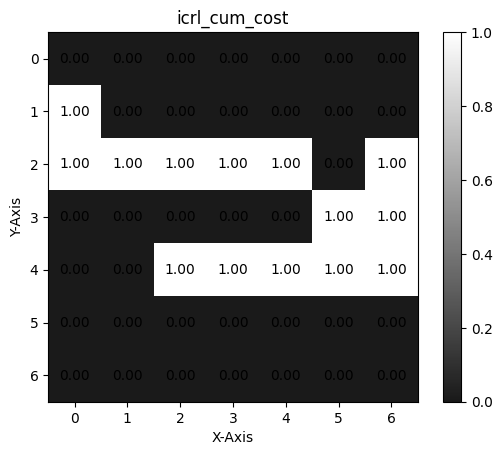

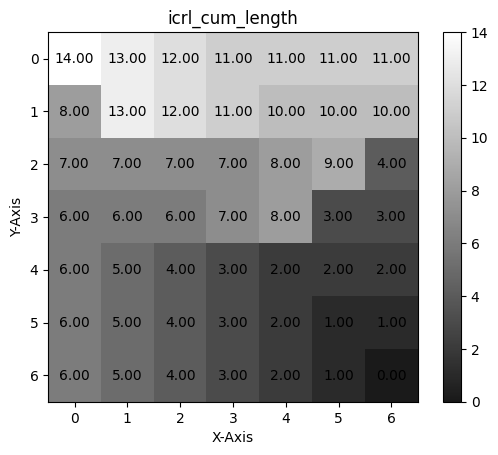

In [4]:
plotimg(cum_cost,"icrl_cum_cost")
plotimg(cum_length,"icrl_cum_length")
